# Week 3 Lab: Point Data in R

## 0. Introduction

This lab is the first of five R labs:

- Week 3 Lab: Point Data in R
- Week 4 Lab: Vector Data in R
- Week 5 Lab: Raster Data in R
- Week 6 Lab: Connectivit Modeling in R
- Week 7 Lab: Map Design in R

Together, these labs present a Worked Example that you can adapt:

- In class, modify the code to illustrate your own access to public services, using your own points from Week 1 Lab
- Later, modify the code to solve the Case Study Assignment 

### a) Data used

This lab uses the `.csv` file "MyPoints.csv" created by your instructor. You can modify the code to use your own file. 

The file contains lat/lon coordinates of the nearest access to public services (from home):

- major intersection (proxy for home, used to protect personal information)
- transit stop
- hospital ER
- pharmacy, 
- elementary school
- high school
- government services e.g. Service Ontario

### b) Main steps

1. Import the point data digitized in Week 1 Lab and add attribute data
2. Convert to a spatial data object in R and define the projection
3. Calculate the distance from home (i.e., nearest major intersection) to public services
4. Export the spatial data in a shareable format (ESRI shapefile)
5. Plot the points on a base map from the internet

### c) R packages

Execute the following code to load the necessary R packages. They should already be installed.


In [1]:
library(sf)
if (!require("ggmap")) install.packages("ggmap", dependencies=TRUE)
library(ggmap)
install.packages("ggplot2")
library(ggplot2)
if (!require("lwgeom")) install.packages("lwgeom", dependencies=TRUE)
library(lwgeom)

Linking to GEOS 3.5.1, GDAL 2.1.2, proj.4 4.9.3
Loading required package: ggmap
Loading required package: ggplot2
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Loading required package: lwgeom
Linking to liblwgeom 2.3.1 r15264, GEOS 3.5.1, proj.4 4.9.3


In [2]:
packageVersion("ggplot2")

[1] ‘2.2.1’

## 1. Import point data and add attribute data

### a) Import point data from file

To import your own data file:

- Upload the file into the workspace
- In the code below, change the filename `MyPoints.csv` to match your own file

In [3]:
MyPoints <- read.csv(file = "MyPoints.csv")
MyPoints

Label,Latitude,Longitude
Intersection,43.63110,-79.35694
Transit stop,43.63144,-79.35780
Hospital ER,43.65865,-79.38647
Pharmacy,43.64162,-79.38015
Elementary school,43.61632,-79.37857
High school,43.68094,-79.43622
Services Ontario,43.65023,-79.37695


### b) Calculate raw distances from the spatial coordinates

Latitude and Longitude are spatial coordinates, but R does not yet know that, it treats them as any quantitative (numeric) data. Let's see what happens if we calculate two-dimensional Euclidean distances among the points. 

The code does the following:

- Create a new object coords that contains only the two columns with the coordinate data
- Use the column Label as row names for coords, so that the output will be labeled
- Calculate two-dimensional Euclidean distances between points
- List the output as a distance matrix

In [4]:
coords <- MyPoints[,c("Latitude", "Longitude")]
row.names(coords) <- MyPoints$Label
Distances.raw <- as.matrix(dist(coords))
round(Distances.raw,4)

,Intersection,Transit stop,Hospital ER,Pharmacy,Elementary school,High school,Services Ontario
Intersection,0.0000,0.0009,0.0404,0.0255,0.0262,0.0937,0.0277
Transit stop,0.0009,0.0000,0.0395,0.0246,0.0257,0.0927,0.0268
Hospital ER,0.0404,0.0395,0.0000,0.0182,0.0431,0.0545,0.0127
Pharmacy,0.0255,0.0246,0.0182,0.0000,0.0254,0.0685,0.0092
Elementary school,0.0262,0.0257,0.0431,0.0254,0.0000,0.0866,0.0339
High school,0.0937,0.0927,0.0545,0.0685,0.0866,0.0000,0.0668
Services Ontario,0.0277,0.0268,0.0127,0.0092,0.0339,0.0668,0.0000


**Questions**:

- Where do we find the distances from the nearest intersection to public services?
- What are the units of these distances?
- Is this a realistic measure of physical distance?

### c) Add attribute data

An R data frame can hold various types of data. When converting to a spatial object, we will distinguish between:

- **Geometry**: the spatial reference data (here, point coordinates). This describes **where** something is.
- **Attribute data**: the variables, like `Label` here, that describe **what** something is.

Let's add a unique and short ID variable, which is also considered attribute data. We create the ID by pasting two strings together:

- "Pt" for point
- A line number (i.e., 1 through the number of lines in the data frame): `1:nrow(MyPoints)`
- We specify that there should be no divider between the two parts: `sep = ""`

In [5]:
MyPoints$ID <- paste("Pt", 1:nrow(MyPoints), sep="")

We can reorder the columns. Here we simply use the column numbers to specify the order. This order will make it easier to read: ID, attribute data, geometry data.

How does this work?

- With the square brackets, we subset elements of the object `MyPoints`.
- The object `MyPoints` has two dimensions: rows and columns (in that order).
- Thus, `MyPoints[1,3]` refers to the element in the first row and the third column of `MyPoints`.
- For a data frame like `MyPoints`, we can refer to the column names, or to the column number (1, 2, ...)
- Thus, `c(4,1,3,2)` tells R to sort the columns, taking the 4th column first, then the first, etc. 
- Here, we chose to list `Longitude` before `Latitude`, because `Longitude` refers to the x-coordinate and `Latitude` to the y-coordinate. 

In [6]:
MyPoints <- MyPoints[,c(4,1,3,2)]
MyPoints

ID,Label,Longitude,Latitude
Pt1,Intersection,-79.35694,43.63110
Pt2,Transit stop,-79.35780,43.63144
Pt3,Hospital ER,-79.38647,43.65865
Pt4,Pharmacy,-79.38015,43.64162
Pt5,Elementary school,-79.37857,43.61632
Pt6,High school,-79.43622,43.68094
Pt7,Services Ontario,-79.37695,43.65023


## 2. Convert to a spatial data object

There are special R object types to hold spatial data, and functions that know what to do with them. 

### a) Convert to sf object

Here we convert the data to an `sf` object that can be analyzed e.g. with functions from the package `sf`.  

Notes: 

- `sf::` indicates that the function after the double colon (`st_as_sf`) is a function from the package `sf`. It is good practice in R programming to include this, although it is not needed if we loaded the package.  
- The `st` in `st_as_sf` stands for "spatial type" (can be anything that may be interpreted as spatial data)
- The `sf` in `st_as_sf` stands for "spatial feature" (specific feature types defined in the package `sf`)
- With the arguments `coords`, we specify which variables (columns) contain the x- and y-coordinates. Make sure the column names match your data and that they are listed in the correct order. The first one is expected to increase from West to East (x-axis), the second one to increase from South to North (y-axis).

In [7]:
MyPoints.sf <- sf::st_as_sf(MyPoints, coords=c("Longitude", "Latitude"))
print(MyPoints.sf)

Simple feature collection with 7 features and 2 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -79.43622 ymin: 43.61632 xmax: -79.35694 ymax: 43.68094
epsg (SRID):    NA
proj4string:    NA
   ID             Label                   geometry
1 Pt1      Intersection  POINT (-79.35694 43.6311)
2 Pt2      Transit stop  POINT (-79.3578 43.63144)
3 Pt3       Hospital ER POINT (-79.38647 43.65865)
4 Pt4          Pharmacy POINT (-79.38015 43.64162)
5 Pt5 Elementary school POINT (-79.37857 43.61632)
6 Pt6       High school POINT (-79.43622 43.68094)
7 Pt7  Services Ontario POINT (-79.37695 43.65023)


**Questions**:

- How is this different from the dataframe `MyPoints`?
- What was the effect of defining the argument `coords`?
- How many variables does `MyPoints.df` have? Use the command below to double check.

In [8]:
names(MyPoints.sf)

[1] "ID"       "Label"    "geometry"

### b) Define projection

Don't worry if you don't understand everything in this section!

Now R knows that Longitude and Latitude are spatial coordinates, but it still does not know what type of coordinates!

Define lat/lon projection (projection in which the data were digitized)

- The coordinates returned by Google Maps use a coordinate system with the EPSG code `4326`
- For more information, go to https://epsg.io and enter `4326` in the search field.
- Note: `crs` stands for "coordinate reference system"

In [9]:
sf::st_crs(MyPoints.sf) <- 4326
print(MyPoints.sf)

Simple feature collection with 7 features and 2 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -79.43622 ymin: 43.61632 xmax: -79.35694 ymax: 43.68094
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs
   ID             Label                   geometry
1 Pt1      Intersection  POINT (-79.35694 43.6311)
2 Pt2      Transit stop  POINT (-79.3578 43.63144)
3 Pt3       Hospital ER POINT (-79.38647 43.65865)
4 Pt4          Pharmacy POINT (-79.38015 43.64162)
5 Pt5 Elementary school POINT (-79.37857 43.61632)
6 Pt6       High school POINT (-79.43622 43.68094)
7 Pt7  Services Ontario POINT (-79.37695 43.65023)


**Question**:

- What happened with the object `MyPoints.sf`? What was added?

## 3. Calculate distances from nearest intersection


### a) Use dedicated function for `sf` objects

Now that R knows the projection, will it calculate more realistic distances?

- Calculate distances, write them into object `Distances`
- Define the row and column labels to facilitate interpretation
- Print the first column only (distances from Intersection), round to full meters (zero decimals).

In [10]:
Distances <- sf::st_distance(MyPoints.sf) 
rownames(Distances) <- colnames(Distances) <- MyPoints.sf$Label
round(Distances[,1],0)

Units: m
     Intersection      Transit stop       Hospital ER          Pharmacy 
                0                79              3880              2209 
Elementary school       High school  Services Ontario 
             2397              8460              2669 

**Questions**:

- What are the units?
- Are these distances realistic?
- Within what distance do you have access to key public services? Compare the maximum distance of your data set with other students in the class. What is the range (minimum, maximum)?
- Think of our case study. Within what distance do you think the community will have access to these types of services?

## 4. Export Data

### a) Export as an RDS file

First, we'll write the spatial object `MyPoints.sf` into an external file with extension `.rds`. This is a file format specific to R and can't easily be read by other software.

- Here we check first if the folder `output` exists, and if not, we create it.
- Then we use `saveRDS` to write the data into file `MyPoints.rds`.

In [11]:
if(!dir.exists("output")) dir.create("output")
saveRDS(MyPoints.sf, "output/MyPoints.rds")

### b) Export as an ESRI shapefile

Now that we have a spatial feature data set with point data, we can convert it to an ESRI shapefile with point data. Shapefiles are a commonly used standard for exchanging spatial data layers.

First we create a folder with the name of the exported object, inside the folder `output`. 

- Here we check first if the folder exists, and if not, we create a folder `MyPointsExport` inside the folder `output`.
- Then we export the object `MyPoints.sf` as a shapfile with name `MyPoints.shp`.
- We use the argument `update = TRUE` to overwrite the file if it already exists.

In [12]:
if(!dir.exists("output/MyPointsExport")) dir.create("output/MyPointsExport")
st_write(MyPoints.sf, "output/MyPointsExport/MyPoints.shp", delete_layer=TRUE)

Deleting layer `MyPoints' using driver `ESRI Shapefile'
Writing layer `MyPoints' to data source `/home/rstudio/output/MyPointsExport/MyPoints.shp' using driver `ESRI Shapefile'
features:       7
fields:         2
geometry type:  Point


**Questions**:

- How many files were created in the folder `MyPointsExport`?
- Google the components of ESRI shapefiles. E.g. here: https://desktop.arcgis.com/en/arcmap/10.3/manage-data/shapefiles/shapefile-file-extensions.htm
- Which components were generated, and what do they contain?
- Have another look at the summary display of the `MyPoints.sf` object below. Which information most likely went into which component of the ESRI shapefile?
- Note: ALWAYS copy/move/share the entire folder with all components of a shapefile, NEVER copy/move/share only the `.shp` file. 

In [13]:
print(MyPoints.sf)

Simple feature collection with 7 features and 2 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -79.43622 ymin: 43.61632 xmax: -79.35694 ymax: 43.68094
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs
   ID             Label                   geometry
1 Pt1      Intersection  POINT (-79.35694 43.6311)
2 Pt2      Transit stop  POINT (-79.3578 43.63144)
3 Pt3       Hospital ER POINT (-79.38647 43.65865)
4 Pt4          Pharmacy POINT (-79.38015 43.64162)
5 Pt5 Elementary school POINT (-79.37857 43.61632)
6 Pt6       High school POINT (-79.43622 43.68094)
7 Pt7  Services Ontario POINT (-79.37695 43.65023)


## 5. Plot the points on a base map from the internet

We'll learn more about map design in a later lab. For now, let's use the code below to visualize the points and check that they are in the right location. Don't worry if you don't understand the code at this time. 

### a) Define the spatial extent of the map

We'll extend the map a bit beyond the points in all directions.

In [14]:
Bbox <- sf::st_bbox(MyPoints.sf)
xrange <- Bbox$xmax - Bbox$xmin # range of x values
yrange <- Bbox$ymax - Bbox$ymin # range of y values

Bbox[1] <- Bbox[1] - (0.5 * xrange) # xmin - left
Bbox[3] <- Bbox[3] + (0.5 * xrange) # xmax - right
Bbox[2] <- Bbox[2] - (0.5 * yrange) # ymin - bottom
Bbox[4] <- Bbox[4] + (0.5 * yrange) # ymax - top

names(Bbox) <- c("left",   "bottom", "right",  "top")

### b) Download a basemap from the internet

In [15]:
#basemap <- ggmap::get_stamenmap(Bbox, zoom = 13, maptype = c("terrain"), color = c("color"))
basemap <- ggmap::get_stamenmap(Bbox, zoom = 13, maptype = c("toner-lite"), color = c("color"))

Map from URL : http://tile.stamen.com/toner-lite/13/2287/2987.png
Map from URL : http://tile.stamen.com/toner-lite/13/2288/2987.png
Map from URL : http://tile.stamen.com/toner-lite/13/2289/2987.png
Map from URL : http://tile.stamen.com/toner-lite/13/2290/2987.png
Map from URL : http://tile.stamen.com/toner-lite/13/2291/2987.png
Map from URL : http://tile.stamen.com/toner-lite/13/2287/2988.png
Map from URL : http://tile.stamen.com/toner-lite/13/2288/2988.png
Map from URL : http://tile.stamen.com/toner-lite/13/2289/2988.png
Map from URL : http://tile.stamen.com/toner-lite/13/2290/2988.png
Map from URL : http://tile.stamen.com/toner-lite/13/2291/2988.png
Map from URL : http://tile.stamen.com/toner-lite/13/2287/2989.png
Map from URL : http://tile.stamen.com/toner-lite/13/2288/2989.png
Map from URL : http://tile.stamen.com/toner-lite/13/2289/2989.png
Map from URL : http://tile.stamen.com/toner-lite/13/2290/2989.png
Map from URL : http://tile.stamen.com/toner-lite/13/2291/2989.png
Map from U

### c) Plot the map and add the points

We will plot the nearest intersection in red and the public services in blue.

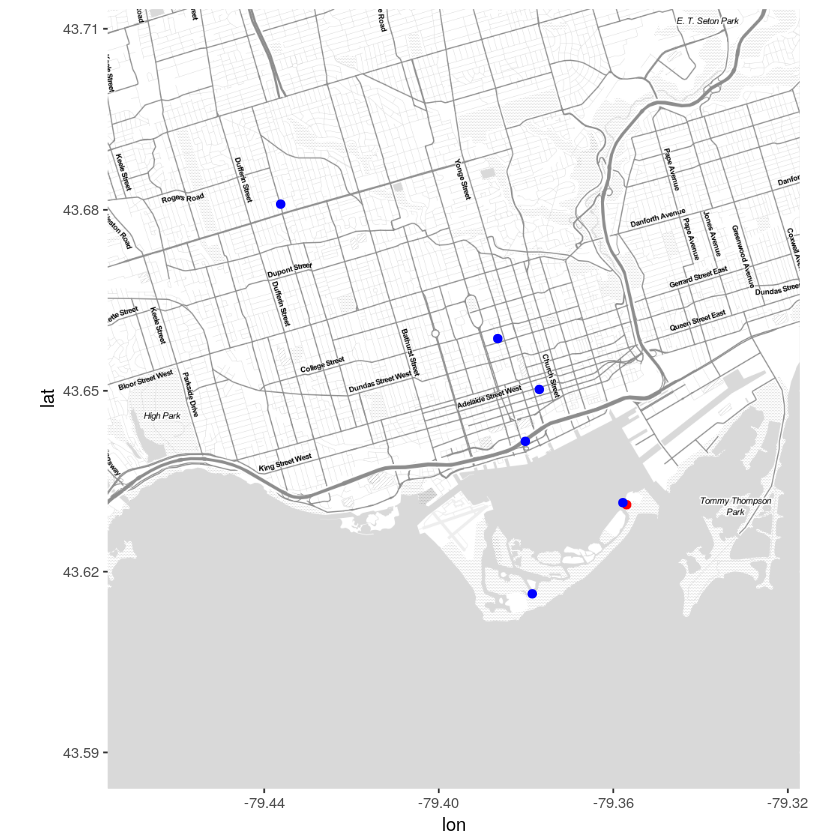

In [16]:
myMap <- ggmap::ggmap(basemap) +
    ggplot2::geom_point(data = MyPoints,
                   mapping = ggplot2::aes(Longitude, Latitude), 
                        size=2, col=c("red", rep("blue", nrow(MyPoints)-1)))
myMap

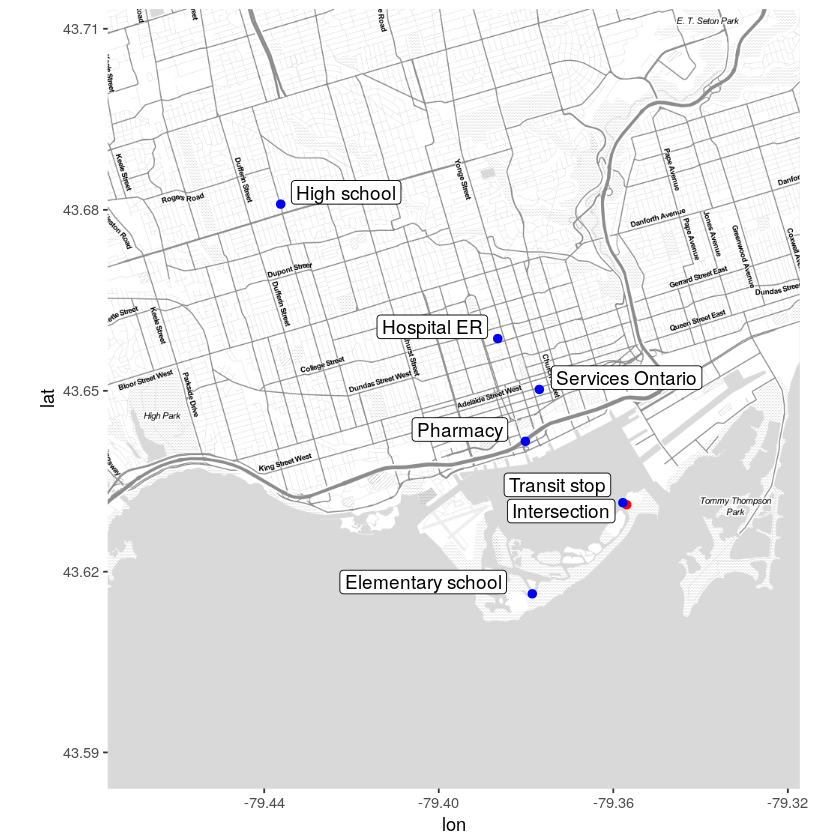

In [17]:
myMap + ggplot2::geom_label(data = MyPoints,
                   mapping = ggplot2::aes(Longitude, Latitude, label = Label),
                   size = 4, label.padding = unit(0.2, "lines"), col = "black", vjust = 0, 
                   nudge_x = c(-0.015, -0.015, -0.015, -0.015, -0.025, 0.015, 0.02), 
                   nudge_y = c(-0.003,  0.001, 0, 0, 0, 0, 0))

### d) Export the map as PDF file. 

The function `ggsave` will save the last-created plot, and it will guess the file type from the extension of the file name provided, here `.pdf`. 

In [18]:
ggplot2::ggsave("output/MyPointsMap.pdf")

Saving 6.67 x 6.67 in image


### e) Export workspace to OneDrive

At the end of each lab, please go to the JupyterHub dashboard, where you see the files, and click `Download Directory`. This will allow you to export all files as a `.zip` archive. Make sure to save it in your OneDrive account, in a folder for the BIO311 labs! 